### Import dependencies

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set();

import re 
import string
import pickle
import warnings 
warnings.filterwarnings("ignore")

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, f1_score


In [2]:
df=pd.read_csv('Datasets/tweets.csv', encoding='iso-8859-1', on_bad_lines='warn', engine="python")
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [3]:
df.columns=['sentiment','id','date','flags','username','text']
df.reset_index(drop=True, inplace=True)
df.head()

,sentiment,id,date,flags,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [4]:
df.tail()

,sentiment,id,date,flags,username,text
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599998,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [5]:
print(f"The shape of the dataset: {df.shape}")

The shape of the dataset: (1599999, 6)


In [6]:
print(f"\n\nSentiment unique values: {df.sentiment.nunique()}\nid unique values: {df.id.nunique()}\ndate unique values: {df.date.nunique()}\nusername unique values: {df.username.nunique()}")



Sentiment unique values: 2
id unique values: 1598314
date unique values: 774362
username unique values: 659775


In [7]:
df.isna().sum()

sentiment    0
id           0
date         0
flags        0
username     0
text         0
dtype: int64

In [8]:
df.date.min(), df.date.max()

('Fri Apr 17 20:30:31 PDT 2009', 'Wed May 27 07:27:38 PDT 2009')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1599999 non-null  int64 
 1   id         1599999 non-null  int64 
 2   date       1599999 non-null  object
 3   flags      1599999 non-null  object
 4   username   1599999 non-null  object
 5   text       1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [10]:
df.groupby('sentiment')['username'].value_counts()[:10]

sentiment  username       
0          lost_dog           549
           tweetpet           310
           webwoke            264
           mcraddictal        210
           wowlew             210
           SallytheShizzle    183
           _magic8ball        136
           Dogbook            133
           mrs_mcsupergirl    123
           nuttychris         121
Name: username, dtype: int64

In [11]:
print(df[df['sentiment']==0].iloc[np.random.randint(0,800000), -1])

i'm crying so much! i can't watch the mcfly videos in Brazil! they're so perfect! i wanted to go back in time! love ya!  i want them! 


In [12]:
print(df[df['sentiment']==4].iloc[np.random.randint(0,800000),-1])

@Haunted_Girl broke my previous white one, had to get another one,my wallet &amp; phone are white so want to have matching colors like a pimp 


### EDA

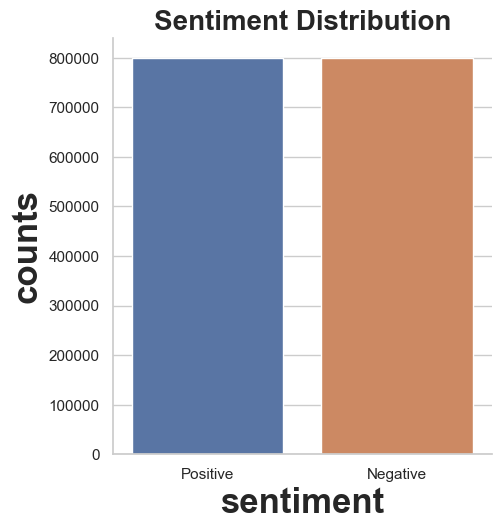

In [13]:
sns.set(style="whitegrid", color_codes=True)
ax=sns.catplot('sentiment', data=df, kind='count')
plt.title("Sentiment Distribution", size=20, weight="bold")
plt.xlabel('sentiment', size=25, weight="bold")
plt.ylabel("counts", size=25, weight="bold")
ax.set_xticklabels(['Positive','Negative'], rotation=0)
plt.show();

In [14]:
data_neg=df[df['sentiment']==0]
data_pos=df[df['sentiment']==4]

In [15]:
data_pos.shape

(800000, 6)

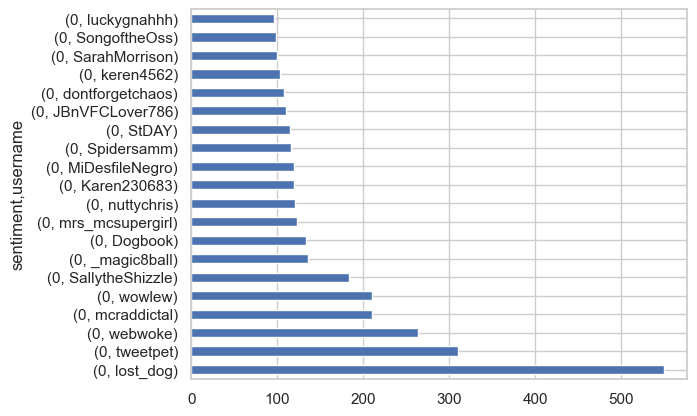

In [16]:
data_neg.groupby('sentiment')['username'].value_counts()[:20].plot(kind='barh');

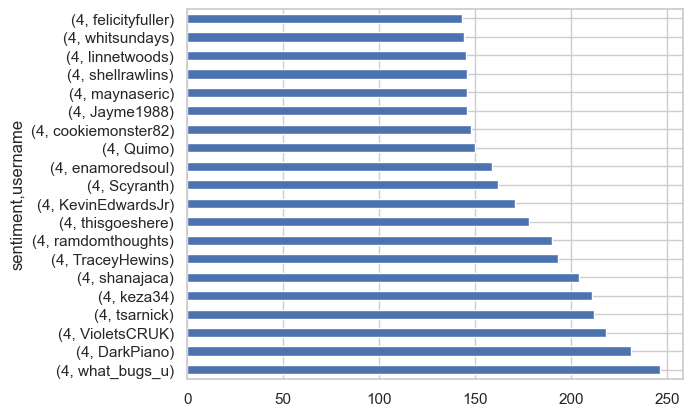

In [17]:
data_pos.groupby('sentiment')['username'].value_counts()[:20].plot(kind="barh");

In [18]:
def get_top_word_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_word_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

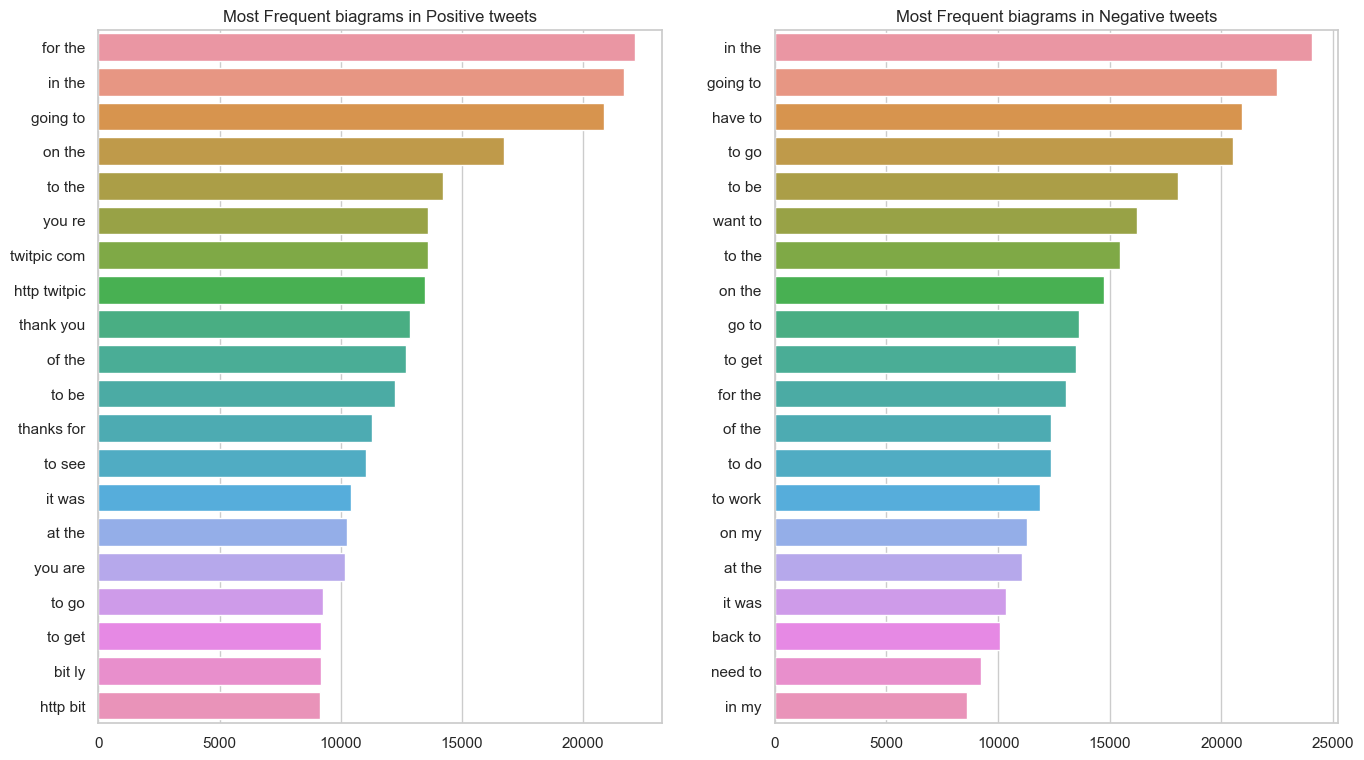

In [19]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(16,9))
top_tweet_bigrams_pos=get_top_word_bigrams(data_pos['text'])[:20]
x,y=map(list,zip(*top_tweet_bigrams_pos))
sns.barplot(x=y,y=x,ax=ax[0])

top_tweet_bigrams_neg=get_top_word_bigrams(data_neg['text'])[:20]
x,y=map(list,zip(*top_tweet_bigrams_neg))
sns.barplot(x=y,y=x,ax=ax[1])

ax[0].set_title("Most Frequent biagrams in Positive tweets")
ax[1].set_title("Most Frequent biagrams in Negative tweets")
plt.show()

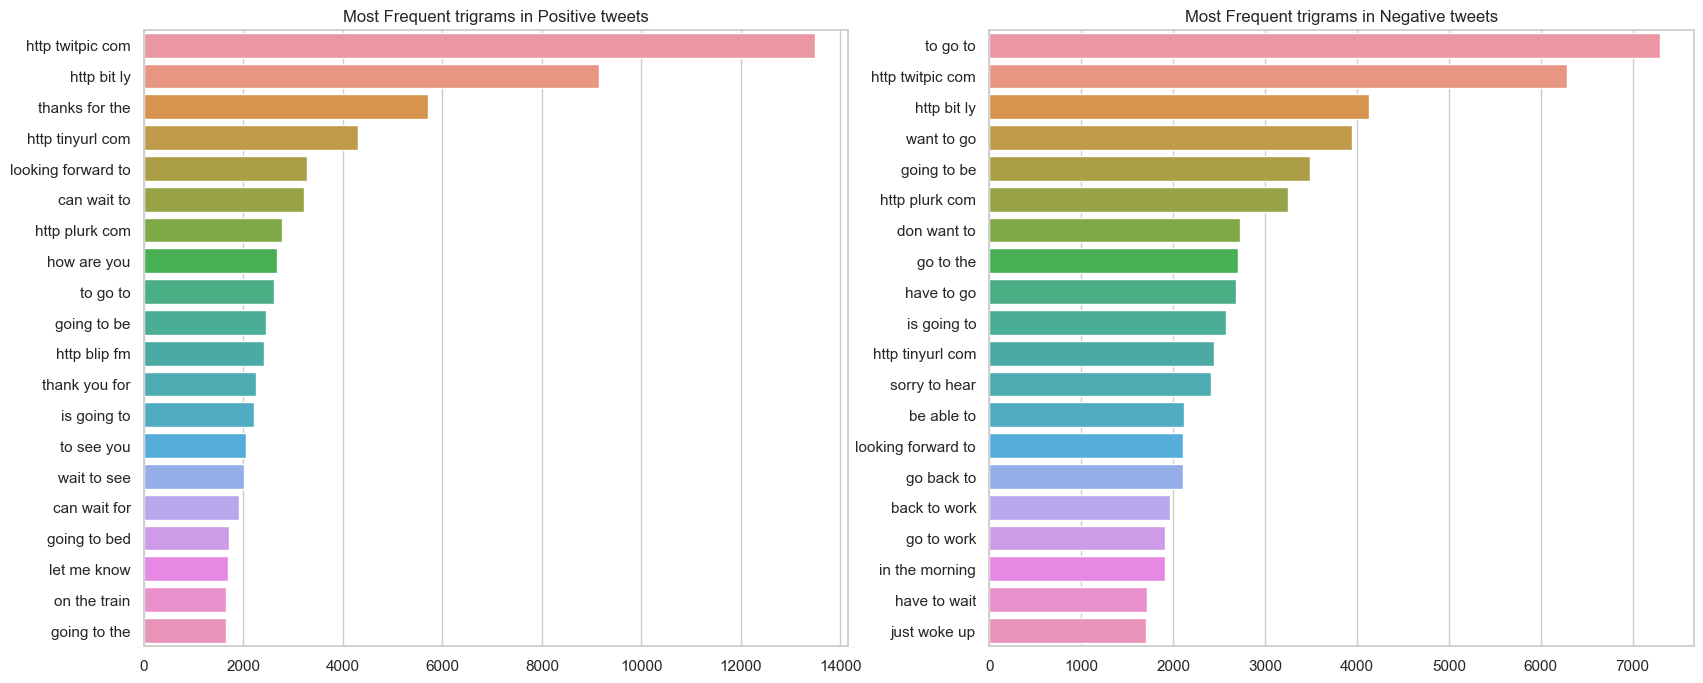

In [20]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,8))
top_tweet_trigrams_pos=get_top_word_trigrams(data_pos['text'])[:20]
x,y=map(list,zip(*top_tweet_trigrams_pos))
sns.barplot(x=y,y=x,ax=ax[0])

top_tweet_trigrams_neg=get_top_word_trigrams(data_neg['text'])[:20]
x,y=map(list,zip(*top_tweet_trigrams_neg))
sns.barplot(x=y,y=x,ax=ax[1])
ax[0].set_title("Most Frequent trigrams in Positive tweets")
ax[1].set_title("Most Frequent trigrams in Negative tweets")
plt.show()

In [21]:
tweets_per_day=df.groupby('date')['text'].value_counts().sort_values(ascending=False)
tpd_df=pd.DataFrame(dict(zip(tweets_per_day.index, tweets_per_day.values)), index=[0]).\
    melt(var_name='Date', value_name="Counts")

tpd_df.loc[:10]

,Date,Counts
0,Fri May 22 05:10:17 PDT 2009,14
1,Mon May 18 06:18:26 PDT 2009,7
2,Mon Jun 15 01:42:13 PDT 2009,6
3,Sun May 03 22:11:28 PDT 2009,5
4,Wed Jun 24 21:29:17 PDT 2009,4
5,Sun May 31 18:28:16 PDT 2009,4
6,Sun May 31 17:50:18 PDT 2009,4
7,Fri May 29 14:08:06 PDT 2009,3
8,Sun Jun 07 04:55:23 PDT 2009,3
9,Sat May 02 01:06:40 PDT 2009,3


In [22]:
df.date.value_counts().sort_values(ascending=False)[:15]

Mon Jun 15 12:53:14 PDT 2009    20
Mon Jun 15 13:39:50 PDT 2009    17
Fri May 22 05:10:17 PDT 2009    17
Fri May 29 13:40:04 PDT 2009    17
Fri Jun 05 11:05:33 PDT 2009    16
Fri Jun 05 14:13:07 PDT 2009    16
Sat Jun 06 11:59:49 PDT 2009    15
Mon Jun 15 10:39:32 PDT 2009    15
Fri Jun 05 09:45:09 PDT 2009    15
Mon Jun 01 15:19:07 PDT 2009    15
Fri May 29 10:09:34 PDT 2009    15
Sat May 30 07:53:15 PDT 2009    15
Fri Jun 05 14:17:04 PDT 2009    15
Mon Jun 01 12:25:21 PDT 2009    15
Fri May 22 08:34:27 PDT 2009    15
Name: date, dtype: int64

### Data Preprocessing

In [23]:
def clean_tweet(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    stop_words=set(stopwords.words("english"))
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # only removing the hash # sign from the word
    text = re.sub(r'#', '', str(text)) 
    # remove punctuation
    punct = set(string.punctuation)
    text = "".join(ch for ch in text if ch not in punct) 
    " ".join(word for word in text.split() if word not in stop_words)
    
    return text
 

In [24]:
df['clean_text']=df['text'].apply(clean_tweet)
df.head()

,sentiment,id,date,flags,username,text,clean_text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset cant update facebook texting it might cr...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dived many times ball managed save ...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole body feels itchy like fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass no behaving all im mad here ca...
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew,kwesidei whole crew


### Wordclouds

- For Negative Sentiment tweets

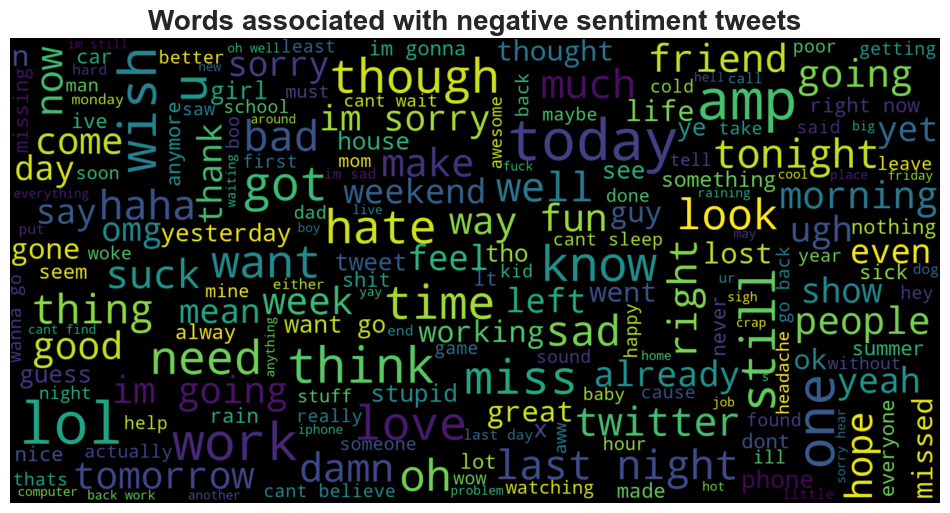

In [25]:
neg=" ".join([tweet for tweet in df[df['sentiment']==0]['clean_text']])

wc=WordCloud(width=1600, height=800, max_font_size=100, max_words=200, random_state=24).generate(neg)

plt.figure(figsize=(12,8))
plt.imshow(wc, interpolation='bilinear')
plt.title("Words associated with negative sentiment tweets", size=20, weight='bold')
plt.axis('off')
plt.show()

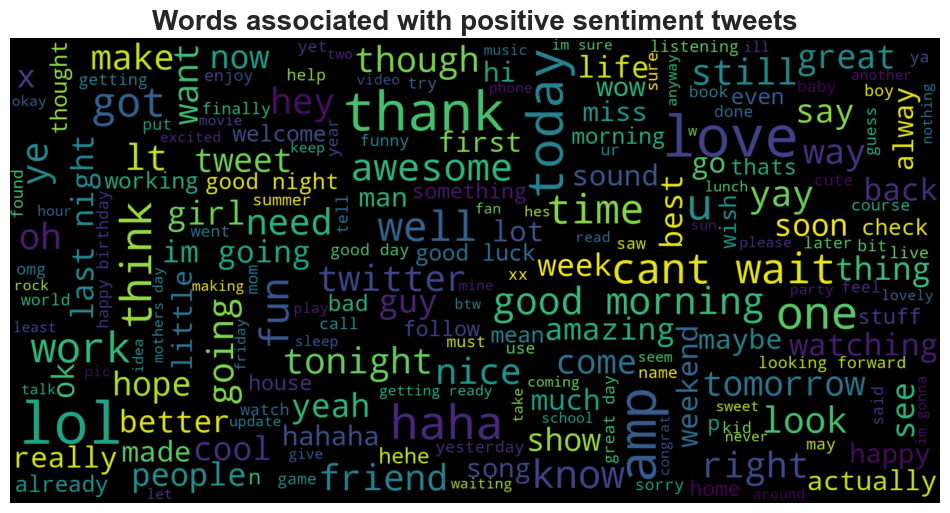

In [26]:
pos=' '.join([tweet for tweet in df[df['sentiment']==4]['clean_text']])

wc=WordCloud(width=1600, height=800, max_font_size=100, max_words=200, random_state=24).generate(pos)

plt.figure(figsize=(12,8))
plt.title("Words associated with positive sentiment tweets", size=20, weight='bold')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show();

### Building the Models

- Vectorize the text

In [27]:
cv= CountVectorizer(binary=True)
cv.fit(df['clean_text'].values.tolist())
train_cv=cv.transform(df['clean_text'])


tf=TfidfVectorizer(ngram_range=(1,2), max_features=500000)
tf.fit(df['clean_text'].values.tolist())
train_tf=tf.transform(df['clean_text'])

- Target variable

In [28]:
y=df['sentiment']

- splitting the data

In [29]:
X_train, X_test, y_train, y_test=train_test_split(train_tf,y, train_size=0.3, random_state=42)

- model development

In [32]:
models={
    "SVM": LinearSVC(),
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost":XGBClassifier()
}

vectors={
    "CountVectorizer" : train_cv,
    "TfidfVectorizer": train_tf
}

In [36]:
def execution(classification_model: str, sample: str, y):
    
    results= {}
    
    results['model_name']=classification_model+ "_" + sample
    
    model=models[classification_model]
    X= vectors[sample]
    
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    
    results['f1_score']=f1_score(y_test, y_pred, pos_label=0)
    
    return results

In [ ]:
all_models=[]

for classification_model in models:
    for sample in vectors:
        all_models.append(execution (classification_model, sample, y))
        print(f"Model: {classification_model}_{sample}...\n")

In [ ]:
models_df=pd.DataFrame(all_models)
model_df

### Preprocessing the text

In [ ]:
def  preprocessing (textdata):
    processedText=[]

    #create lemmatizer and stemmer
    wordlemm=WordNetLemmatizer()

    #Defining Regex patterns
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"


    for tweet in textdata:
        tweet=tweet.lower()


        #Replace URLs with 'URL'
        tweet=re.sub(urlPattern, 'URL', tweet)

        #Replace all emojis
        for emoji in emojis.keys():
            tweet=tweet.replace(emoji, "EMOJI" + emojis[emoji])

        #replace @USERNAME to USER
        tweet=re.sub(userPattern,'USER',tweet)

        #Replace all non alphabets
        tweet=re.sub(alphaPattern, " ", tweet)
        
        #Replace 3 or more consecutive letters only by 2 letter.
        tweet=re.sub(sequencePattern, seqReplacePattern,tweet)

        tweetwords=''
        for word in tweet.split():
            #checking if a word is a stopword
            #if word not in stopwordlist
            if len(word)>1:
                #lemmatizing the word
                word=wordlemm.lemmatize(word)
                tweetwords += (word+' ')

        processedText.append(tweetwords)

    return processedText

In [ ]:
import time
t=time.time()
processedtext=preprocessing(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

##### Analysing the data
Using wordcloud for both positive and negative tweets

- WordCloud for Negative tweets

In [ ]:
data_neg=processedtext[:800000]
plt.figure(figsize=(20,20))
wc=WordCloud(max_words=1000, width=1600, height=800, collocations=False).generate(" ".join(data_neg))
plt.imshow(wc);

- WordCloud for Positive tweets

In [ ]:
data_pos=processedtext[:800000]
plt.figure(figsize=(2020))
wc=WordCloud(max_words=1000, width=1600, height=800, collocations=False).generate(" ".join(data_pos))

plt.imshow(wc)

#### Splitting the data

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(processedtext, sentiment, test_size=0.30, random_state=0)
print(f'Data Split done.')

#### TF-IDF Vectorizer
It indicates the importance of a word in a sentence, it converts raw documents into a matrix of TF-IDF features.

In [ ]:
vectorizer=TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectorizer.fit(X_train)
print(f'Vectorizer fitted.')
print("No. of feature_words: ",len(vectorizer.get_feature_names()) )

#### Transforming the dataset
X_train and X_test is transformed into TF-IDF feature matrix

In [ ]:
X_train=vectorizer.transform(X_train)
X_test=vectorizer.transform(X_test)
print(f'Data Transformed.')